# Hyperbolic unitary cost function ADAM gradient descent SPT extraction

Created 04/11/2024

Objectives:
* Update "hyperboilc unitary cost function gradient descent SPT extraction" to use ADAM gradient descent instead.

# Package imports

In [1]:
import sys
sys.path.append('../../')

In [2]:
import h5py
from tenpy.tools import hdf5_io
import tenpy
import tenpy.linalg.np_conserved as npc

import os

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy

In [4]:
from functools import reduce 

In [5]:
from SPTOptimization.SymmetryActionWithBoundaryUnitaries import SymmetryActionWithBoundaryUnitaries

from SPTOptimization.utils import to_npc_array

In [6]:
import re

# Load data

In [7]:
DATA_DIR = r"../../data/transverse_cluster_200_site_dmrg"

In [8]:
loaded_data = list()

for local_file_name in os.listdir(DATA_DIR):
    f_name = r"{}/{}".format(DATA_DIR, local_file_name, ignore_unknown=False)
    with h5py.File(f_name, 'r') as f:
        data = hdf5_io.load_from_hdf5(f)
        loaded_data.append(data)

In [9]:
b_parameters = sorted(list(d['paramters']['B'] for d in loaded_data))

In [10]:
psi_dict = dict()

In [11]:
for b in b_parameters:
    psi = next(
        d['wavefunction']
        for d in loaded_data
        if d['paramters']['B'] == b
    )

    rounded_b = round(b, 1)
    psi_dict[rounded_b] = psi

# Definitions

In [12]:
np_I = np.array([[1,0],[0,1]])
np_X = np.array([[0,1],[1,0]])
np_Y = np.array([[0,-1j],[1j,0]])
np_Z = np.array([[1,0],[0,-1]])

In [13]:
symmetry_actions = [
    [np_I, np_I],
    [np_I, np_X],
    [np_X, np_I],
    [np_X, np_X]
]

In [14]:
symmetry_labels = [
    'II',
    'IX',
    'XI',
    'XX'
]

In [15]:
cases = [
    [
        SymmetryActionWithBoundaryUnitaries(
            psi,
            s*50,
            left_boundary_unitaries=[np_I,]*3,
            right_boundary_unitaries=[np_I,]*3
        )
        for s in symmetry_actions
    ]
    for psi in psi_dict.values()
]

In [16]:
for l in cases:
    for c in l:
        c.compute_svd_approximate_expectation()

In [17]:
NUM_SITES = 6

## Functions

In [18]:
P_LEG_LABEL_REGEX_STRING = r"^p\d*$"
p_leg_pattern = re.compile(P_LEG_LABEL_REGEX_STRING)

def is_single_physical_leg_label(label):
    return bool(p_leg_pattern.match(label))

In [19]:
def is_grouped_physical_leg_label(leg_label):
    head, *body, tail = leg_label
    if (head != '(') or (tail != ')'):
        return False

    body = ''.join(body)
    legs = body.split('.')

    return all(is_single_physical_leg_label(l) for l in legs)

In [20]:
def is_physical_leg_label(label):
    out = (
        is_single_physical_leg_label(label)
        or is_grouped_physical_leg_label(label)
    )

    return out

In [21]:
def extract_single_physical_leg_label_from_tensor(b):
    out = next(
        l for l in b.get_leg_labels()
        if is_single_physical_leg_label(l)
    )

    return out

In [22]:
def conjugate_single_physical_leg_label(label):
    return label + '*'

In [23]:
def conjugate_grouped_physical_leg_label(label):
    _, *body, _ = label
    single_labels = ''.join(body).split('.')

    conjugate_labels = [
        conjugate_single_physical_leg_label(l)
        for l in single_labels
    ]

    conjugate_body = '.'.join(conjugate_labels)
    out = '(' + conjugate_body + ')'
    
    return out

In [24]:
def conjugate_leg_label(label):
    if is_single_physical_leg_label(label):
        return conjugate_single_physical_leg_label(label)
    elif is_grouped_physical_leg_label(label):
        return conjugate_grouped_physical_leg_label(label)
    else:
        raise ValueError

In [25]:
def get_physical_leg_labels(t):
    out = [
        ll for ll in t.get_leg_labels()
        if is_physical_leg_label(ll)
    ]

    return out

In [26]:
def get_random_unitary_operator(mps_tensor, dim):
    # To-do: automate getting dimension
    p_leg_label = get_physical_leg_labels(mps_tensor)[0]
    p_leg = mps_tensor.get_leg(p_leg_label)
    p_leg_label_conj = conjugate_leg_label(p_leg_label)
    p_leg_conj = mps_tensor.get_leg(p_leg_label_conj)

    X = scipy.stats.unitary_group.rvs(dim)

    out = npc.Array.from_ndarray(
        X,
        legcharges=[p_leg, p_leg_conj],
        dtype='complex',
        labels=[p_leg_label, p_leg_label_conj]
    )

    return out

In [27]:
def get_identity_operator(mps_tensor):
    p_leg_label = get_physical_leg_labels(mps_tensor)[0]
    p_leg = mps_tensor.get_leg(p_leg_label)
    p_leg_label_conj = conjugate_leg_label(p_leg_label)

    out = npc.diag(
        1,
        leg=p_leg,
        dtype='complex',
        labels=[p_leg_label, p_leg_label_conj]
    )

    return out

### Gradients

In [28]:
def unitarity_gradient(matrix, grouped_physical_leg_label,
                      grouped_physical_leg_conj_label):
    # To-do: Optimise extraction of physical leg labels
    def matrix_multiplication(m1, m2):
        return npc.tensordot(
            m1,
            m2,
            [
                [grouped_physical_leg_label,],
                [grouped_physical_leg_conj_label,]
            ]
        )
    
    t = matrix_multiplication(matrix, matrix.conj())
    score_2 = npc.trace(
        t,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label
    )

    t = matrix_multiplication(t, matrix)

    score_4 = npc.tensordot(
        t,
        matrix.conj(),
        [
            [grouped_physical_leg_label, grouped_physical_leg_conj_label],
            [grouped_physical_leg_conj_label, grouped_physical_leg_label]
        ]
    )

    unitarity_score = score_4 -2*score_2 + matrix.shape[0]

    grad = (t-matrix)/np.sqrt(1+unitarity_score)

    return (t - matrix, unitarity_score)

In [29]:
def overlap_gradient(matrix, reduced_density_matrix,
                     grouped_physical_leg_label,
                     grouped_physical_leg_conj_label,
                     target=1): 

    overlap = npc.tensordot(
        matrix,
        reduced_density_matrix,
        [
            [grouped_physical_leg_label, grouped_physical_leg_conj_label],
            [grouped_physical_leg_conj_label, grouped_physical_leg_label]
        ]
    )

    scale = (overlap - target*overlap/(np.abs(overlap)))
    gradient = scale*reduced_density_matrix.conj()

    return (gradient, overlap)

In [52]:
def squared_components(X):
    r, i = (X.real, X.imag)
    return r**2 + 1j*(i**2)

In [53]:
def square_root_components(X):
    r, i = (X.real, X.imag)
    return np.sqrt(r) + 1j*np.sqrt(i)

In [442]:
class AdamTenpy:
    def __init__(self, alpha=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8):
        self.alpha = alpha
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon

        self.moment_1 = None
        self.moment_2 = None

    def update(self, grad):
        if self.moment_1 is None:
            self.moment_1 = (1-self.beta_1)*grad
        else:
            self.moment_1 = self.beta_1*self.moment_1 + (1-self.beta_1)*grad

        grad_squared = grad.unary_blockwise(squared_components)
        if self.moment_2 is None:
            self.moment_2 = (1-self.beta_2)*grad_squared
        else:
            self.moment_2 = self.beta_2*self.moment_2 + (1-self.beta_2)*grad_squared

        self.moment_1 /= (1-self.beta_1)
        self.moment_2 /= (1-self.beta_2)

        out_grad_denom = (
            self.moment_2
            .unary_blockwise(square_root_components)
            .unary_blockwise(lambda x: x + (1+1j)*self.epsilon)
        )

        out_grad = (
            self.moment_1
            .binary_blockwise(np.divide, out_grad_denom)
        )

        return self.alpha*out_grad

In [312]:
def update(matrix, reduced_density_matrix, unitarity_scores, unitary_cost_scores,
           overlap_scores, target_scores, grouped_physical_leg_label,
           grouped_physical_leg_conj_label, matrix_dim, unitarity_lr,
           overlap_lr, adam_optimizer, target=1):

    u_grad, u_score = unitarity_gradient(
        matrix, grouped_physical_leg_label, grouped_physical_leg_conj_label
    )

    unitarity_scores.append(u_score.real)

    unitary_cost = np.sqrt(1+u_score) - 1
    unitary_cost_scores.append(unitary_cost)

    o_gradient, overlap = overlap_gradient(
        matrix,
        reduced_density_matrix,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label,
        target=target
    )

    overlap_scores.append(np.abs(overlap))

    target_score = (
        (overlap_lr/2.0)*(target - np.abs(overlap))**2 +
        (unitarity_lr/2.0)*unitary_cost.real
    )

    target_scores.append(target_score)

    gradient = unitarity_lr*u_grad + overlap_lr*o_gradient
    adam_grad = adam_optimizer.update(gradient)
    matrix -= adam_grad

# Test

## First

In [415]:
num_sites = 2

In [416]:
matrix_dim = 2**num_sites

In [417]:
unitarity_scores = list()
unitary_cost_scores = list()
overlap_scores = list()
target_scores = list()
solutions = list()

lr = 1
num_iterations = 1000

In [418]:
c = cases[0][1]

In [419]:
sing_val = c.symmetry_transfer_matrix_singular_vals[0]
target = np.power(sing_val, -1/2)

In [420]:
sing_val = c.symmetry_transfer_matrix_singular_vals[0]
target = np.power(sing_val, -1/2)

current_bs = [
    c.psi.get_B(i)
    for i in range(
        c.right_symmetry_index + 1,
        c.right_symmetry_index + 1 + num_sites
    )
]

t = c.right_projected_symmetry_state

for i, b in enumerate(current_bs):
    b_current = b.replace_label('p', f'p{i}')

    t = npc.tensordot(t, b_current, [['vR'], ['vL']])
    t = npc.tensordot(t, b_current.conj(), [['vR*'], ['vL*']])

t = npc.trace(t, 'vR', 'vR*')

leg_labels = [f'p{i}' for i in range(num_sites)]
leg_conj_labels = [f'p{i}*' for i in range(num_sites)]

current_grouped_t = t.combine_legs([leg_labels, leg_conj_labels])

grouped_physical_leg_label = '(' + '.'.join(leg_labels) + ')'
grouped_physical_leg_conj_label = '(' + '.'.join(leg_conj_labels) + ')'

current_matrix = get_random_unitary_operator(current_grouped_t, matrix_dim)

adam_optimizer = AdamTenpy(beta_1 = 0.4, alpha=1e-2)

for _ in range(num_iterations):
    update(
        current_matrix,
        current_grouped_t,
        unitarity_scores,
        unitary_cost_scores,
        overlap_scores,
        target_scores,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label,
        matrix_dim,
        unitarity_lr=lr,
        overlap_lr=lr,
        adam_optimizer=adam_optimizer,
        target=target
    )

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_82648/4077460109.py:3: RuntimeWarning: invalid value encountered in multiply
  return np.sqrt(r) + 1j*np.sqrt(i)


In [421]:
current_matrix.to_ndarray()

array([[ 0.66544596+0.69001377j, -0.02525579+0.22100278j,
         0.13617719+0.03008603j, -0.12228265-0.12364482j],
       [-0.26581252-0.04691513j,  0.50462013+0.79904528j,
         0.09974934-0.05006341j, -0.17591937-0.0911372j ],
       [ 0.01366501+0.09651159j, -0.09738343+0.09070184j,
        -0.69724633-0.70358181j, -0.06922034-0.07423733j],
       [-0.06672774-0.11117298j, -0.02153009-0.23856494j,
         0.0244043 +0.07080233j, -0.64711213-0.72095241j]])

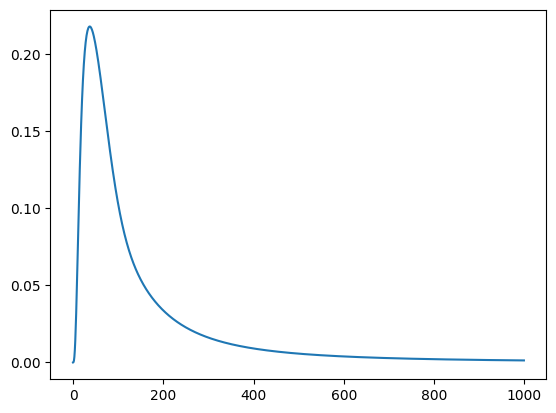

In [422]:
plt.plot(unitarity_scores)

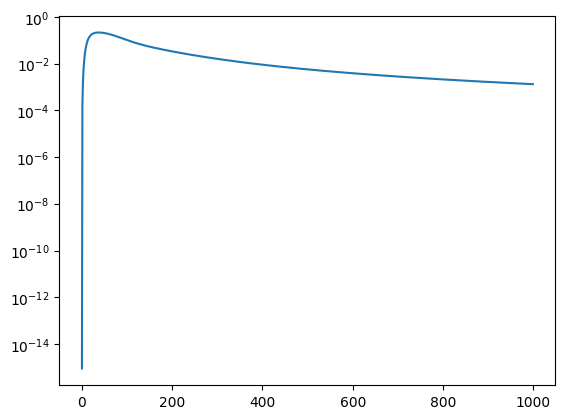

In [423]:
plt.plot(unitarity_scores)
plt.yscale('log')

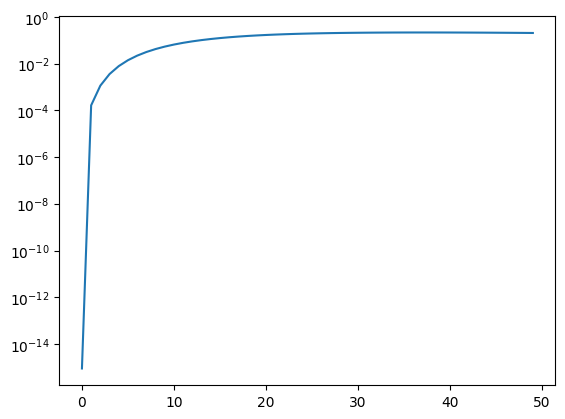

In [424]:
plt.plot(unitarity_scores[:50])
plt.yscale('log')

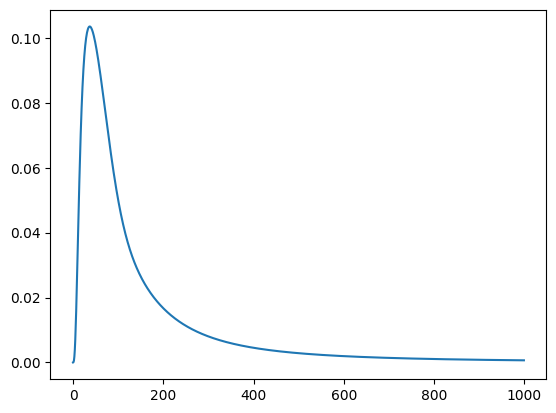

In [425]:
plt.plot(unitary_cost_scores)

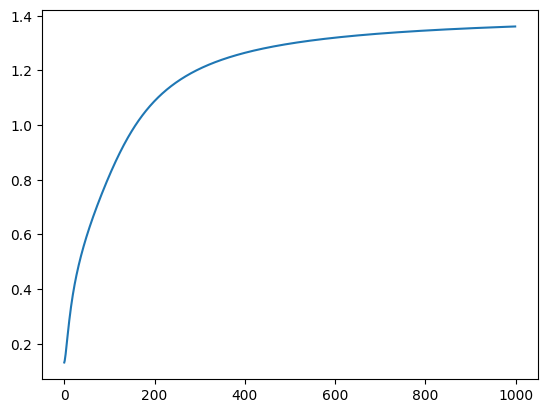

In [426]:
plt.plot(overlap_scores)

In [427]:
overlap_scores[-1]

1.3606100168771431

## Second

In [469]:
num_sites = 2

In [470]:
matrix_dim = 2**num_sites

In [471]:
unitarity_scores = list()
unitary_cost_scores = list()
overlap_scores = list()
target_scores = list()
solutions = list()

lr = 1
num_iterations = 1000

In [472]:
c = cases[0][1]

In [473]:
sing_val = c.symmetry_transfer_matrix_singular_vals[0]
target = np.power(sing_val, -1/2)

In [474]:
sing_val = c.symmetry_transfer_matrix_singular_vals[0]
target = np.power(sing_val, -1/2)

current_bs = [
    c.psi.get_B(i)
    for i in range(
        c.right_symmetry_index + 1,
        c.right_symmetry_index + 1 + num_sites
    )
]

t = c.right_projected_symmetry_state

for i, b in enumerate(current_bs):
    b_current = b.replace_label('p', f'p{i}')

    t = npc.tensordot(t, b_current, [['vR'], ['vL']])
    t = npc.tensordot(t, b_current.conj(), [['vR*'], ['vL*']])

t = npc.trace(t, 'vR', 'vR*')

leg_labels = [f'p{i}' for i in range(num_sites)]
leg_conj_labels = [f'p{i}*' for i in range(num_sites)]

current_grouped_t = t.combine_legs([leg_labels, leg_conj_labels])

grouped_physical_leg_label = '(' + '.'.join(leg_labels) + ')'
grouped_physical_leg_conj_label = '(' + '.'.join(leg_conj_labels) + ')'

current_matrix = get_random_unitary_operator(current_grouped_t, matrix_dim)

adam_optimizer = AdamTenpy(beta_1 = 0.4, beta_2=0.1, alpha=1e-3)

for _ in range(num_iterations):
    update(
        current_matrix,
        current_grouped_t,
        unitarity_scores,
        unitary_cost_scores,
        overlap_scores,
        target_scores,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label,
        matrix_dim,
        unitarity_lr=lr,
        overlap_lr=lr,
        adam_optimizer=adam_optimizer,
        target=target
    )

In [475]:
current_matrix.to_ndarray()

array([[ 0.9792144 -0.20174999j,  0.01250435+0.0005199j ,
         0.01796838+0.02344878j,  0.00373096+0.00227503j],
       [-0.01134268+0.0058259j ,  0.98068907-0.19688126j,
         0.00130657-0.02400378j, -0.03471683+0.01137452j],
       [ 0.01150445-0.02974364j,  0.01198172+0.02064942j,
        -0.98540567+0.17519437j,  0.00258747-0.01895002j],
       [ 0.00510043-0.00423303j, -0.03701248+0.00613163j,
        -0.01053299-0.01347514j, -0.97336725+0.23020444j]])

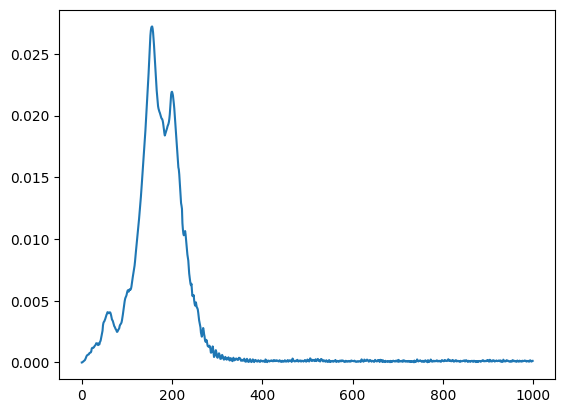

In [476]:
plt.plot(unitarity_scores)

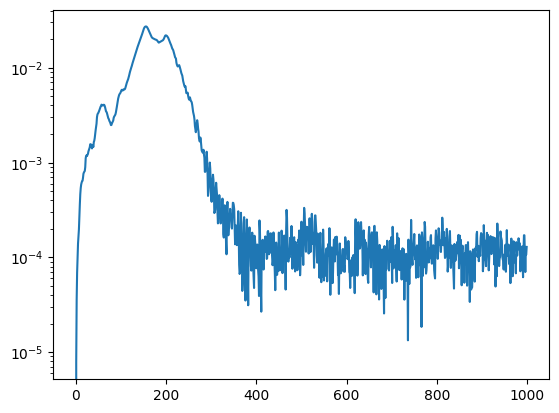

In [477]:
plt.plot(unitarity_scores)
plt.yscale('log')

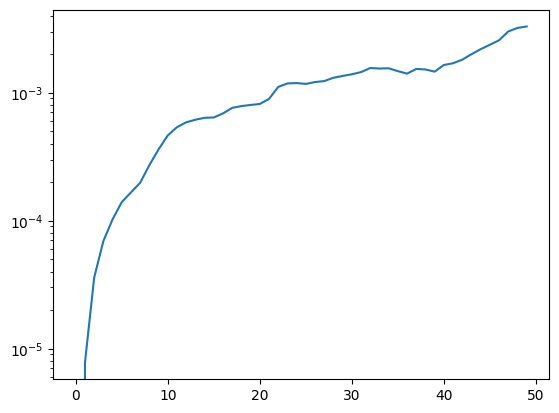

In [478]:
plt.plot(unitarity_scores[:50])
plt.yscale('log')

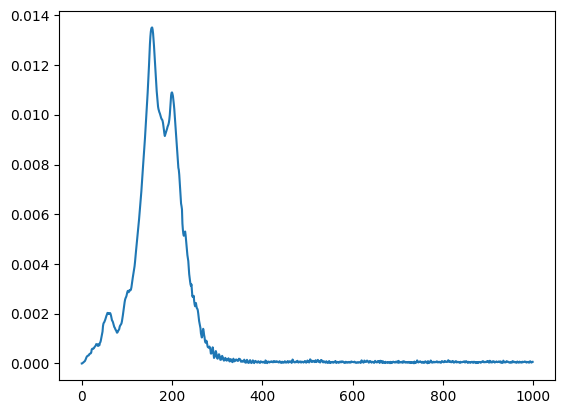

In [479]:
plt.plot(unitary_cost_scores)

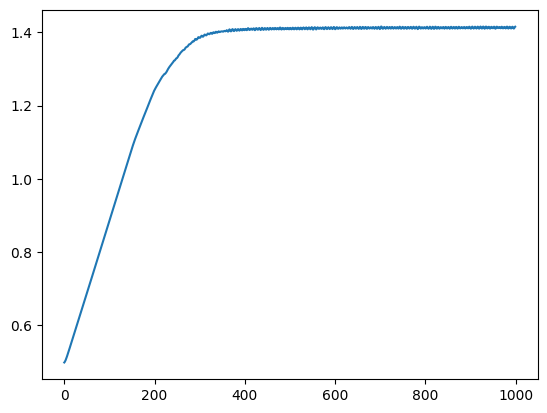

In [480]:
plt.plot(overlap_scores)

In [481]:
overlap_scores[-1]

1.4153730946556078

## Third

In [561]:
num_sites = 2

In [562]:
matrix_dim = 2**num_sites

In [563]:
unitarity_scores = list()
unitary_cost_scores = list()
overlap_scores = list()
target_scores = list()
solutions = list()

lr = 1
num_iterations = 1000

In [564]:
c = cases[0][1]

In [565]:
sing_val = c.symmetry_transfer_matrix_singular_vals[0]
target = np.power(sing_val, -1/2)

In [566]:
sing_val = c.symmetry_transfer_matrix_singular_vals[0]
target = np.power(sing_val, -1/2)

current_bs = [
    c.psi.get_B(i)
    for i in range(
        c.right_symmetry_index + 1,
        c.right_symmetry_index + 1 + num_sites
    )
]

t = c.right_projected_symmetry_state

for i, b in enumerate(current_bs):
    b_current = b.replace_label('p', f'p{i}')

    t = npc.tensordot(t, b_current, [['vR'], ['vL']])
    t = npc.tensordot(t, b_current.conj(), [['vR*'], ['vL*']])

t = npc.trace(t, 'vR', 'vR*')

leg_labels = [f'p{i}' for i in range(num_sites)]
leg_conj_labels = [f'p{i}*' for i in range(num_sites)]

current_grouped_t = t.combine_legs([leg_labels, leg_conj_labels])

grouped_physical_leg_label = '(' + '.'.join(leg_labels) + ')'
grouped_physical_leg_conj_label = '(' + '.'.join(leg_conj_labels) + ')'

current_matrix = get_random_unitary_operator(current_grouped_t, matrix_dim)

adam_optimizer = AdamTenpy(beta_1 = 0.4, beta_2=0.3, alpha=0.5*1e-2)

for _ in range(num_iterations):
    update(
        current_matrix,
        current_grouped_t,
        unitarity_scores,
        unitary_cost_scores,
        overlap_scores,
        target_scores,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label,
        matrix_dim,
        unitarity_lr=lr,
        overlap_lr=lr,
        adam_optimizer=adam_optimizer,
        target=target
    )

In [567]:
current_matrix.to_ndarray()

array([[ 9.57498262e-01+0.28108049j,  3.71140622e-03-0.00872072j,
         7.17915641e-03-0.00313107j,  2.78466334e-03-0.00386792j],
       [ 2.09028917e-03-0.01012119j,  9.60022706e-01+0.27216769j,
        -8.75065249e-03+0.01333937j, -3.26090149e-04+0.00128758j],
       [ 3.20095693e-03+0.00938558j,  1.27282763e-03-0.01760349j,
        -9.44701327e-01-0.32127098j,  1.43029706e-03+0.00962412j],
       [ 8.07883614e-05+0.00498357j,  3.15928687e-04-0.00054151j,
        -8.22026155e-03+0.0063704j , -9.51851335e-01-0.29998799j]])

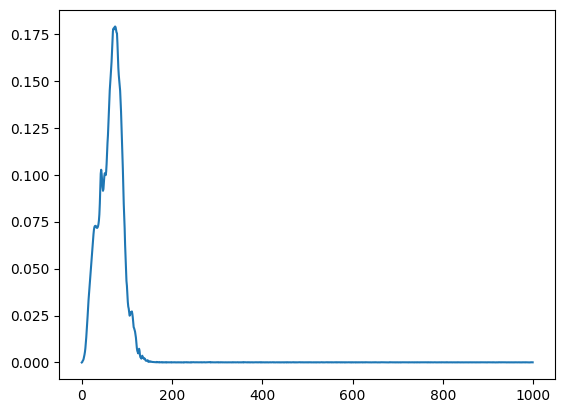

In [568]:
plt.plot(unitarity_scores)

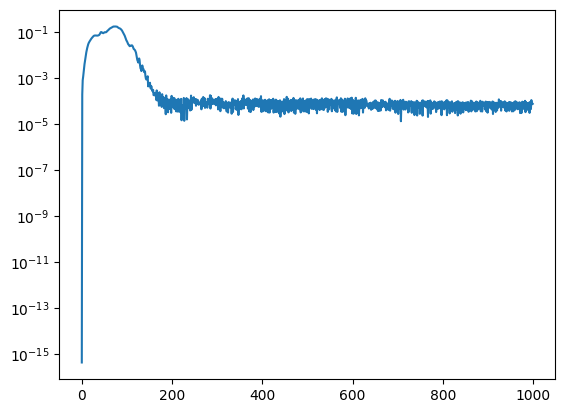

In [569]:
plt.plot(unitarity_scores)
plt.yscale('log')

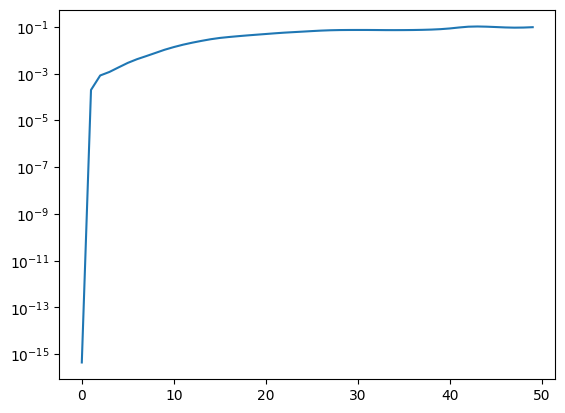

In [570]:
plt.plot(unitarity_scores[:50])
plt.yscale('log')

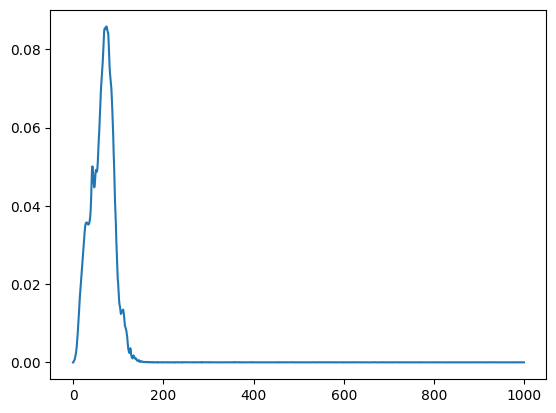

In [571]:
plt.plot(unitary_cost_scores)

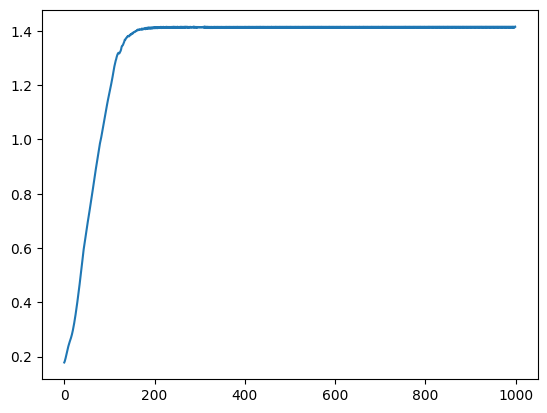

In [572]:
plt.plot(overlap_scores)

In [573]:
overlap_scores[-1]

1.4154747962994807

## Fourth

In [588]:
num_sites = 6

In [589]:
matrix_dim = 2**num_sites

In [590]:
unitarity_scores = list()
unitary_cost_scores = list()
overlap_scores = list()
target_scores = list()
solutions = list()

lr = 1
num_iterations = 1000

In [591]:
c = cases[5][1]

In [592]:
sing_val = c.symmetry_transfer_matrix_singular_vals[0]
target = np.power(sing_val, -1/2)

In [593]:
sing_val = c.symmetry_transfer_matrix_singular_vals[0]
target = np.power(sing_val, -1/2)

current_bs = [
    c.psi.get_B(i)
    for i in range(
        c.right_symmetry_index + 1,
        c.right_symmetry_index + 1 + num_sites
    )
]

t = c.right_projected_symmetry_state

for i, b in enumerate(current_bs):
    b_current = b.replace_label('p', f'p{i}')

    t = npc.tensordot(t, b_current, [['vR'], ['vL']])
    t = npc.tensordot(t, b_current.conj(), [['vR*'], ['vL*']])

t = npc.trace(t, 'vR', 'vR*')

leg_labels = [f'p{i}' for i in range(num_sites)]
leg_conj_labels = [f'p{i}*' for i in range(num_sites)]

current_grouped_t = t.combine_legs([leg_labels, leg_conj_labels])

grouped_physical_leg_label = '(' + '.'.join(leg_labels) + ')'
grouped_physical_leg_conj_label = '(' + '.'.join(leg_conj_labels) + ')'

current_matrix = get_random_unitary_operator(current_grouped_t, matrix_dim)

adam_optimizer = AdamTenpy(beta_1 = 0.3, beta_2=0.3, alpha=0.5*1e-2)

for _ in range(num_iterations):
    update(
        current_matrix,
        current_grouped_t,
        unitarity_scores,
        unitary_cost_scores,
        overlap_scores,
        target_scores,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label,
        matrix_dim,
        unitarity_lr=lr,
        overlap_lr=lr,
        adam_optimizer=adam_optimizer,
        target=target
    )

In [594]:
current_matrix.to_ndarray()

array([[-0.0486608 +0.12929662j,  0.06957305-0.05947662j,
         0.19488504+0.08149579j, ...,  0.156858  -0.09677872j,
        -0.11911753-0.05580909j,  0.03598069+0.10324765j],
       [-0.0067262 -0.07488608j, -0.02786078+0.07374572j,
        -0.04860078+0.10935716j, ...,  0.05087377+0.09258057j,
         0.05369507+0.03852215j, -0.07204456+0.02027579j],
       [ 0.13592537+0.03612619j, -0.07361939+0.12618236j,
         0.18134164+0.08749888j, ..., -0.12013081+0.07750627j,
        -0.04043762-0.06965925j,  0.04922149-0.07685791j],
       ...,
       [ 0.10741814-0.02240372j,  0.02807489-0.00800658j,
        -0.01340879+0.08756523j, ..., -0.26513615+0.10694376j,
         0.07937618+0.00466371j, -0.23759602-0.11211027j],
       [-0.05555754-0.03930639j,  0.00758511-0.06413471j,
         0.05254608+0.03118485j, ..., -0.13567553+0.00952892j,
         0.00835388-0.0383644j , -0.08547353-0.0168701j ],
       [ 0.17117846-0.03328167j, -0.01061036-0.00682221j,
        -0.00172173-0.06264763

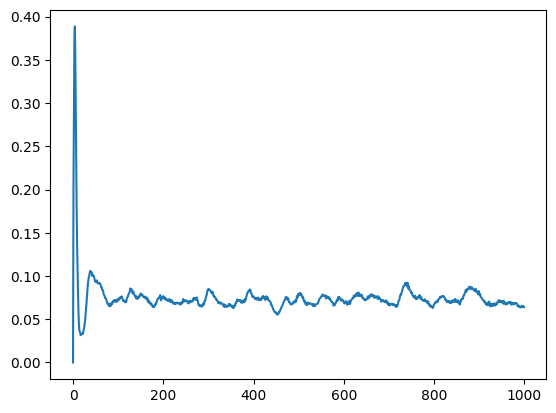

In [595]:
plt.plot(unitarity_scores)

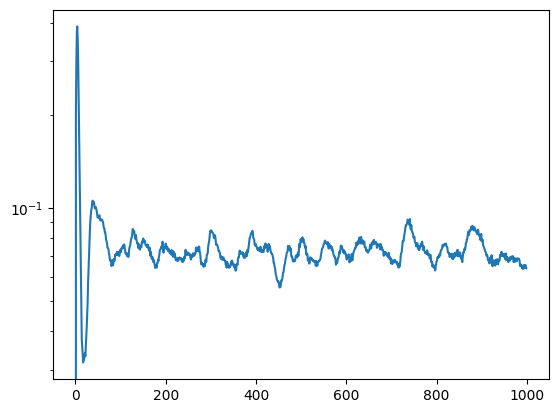

In [596]:
plt.plot(unitarity_scores)
plt.yscale('log')

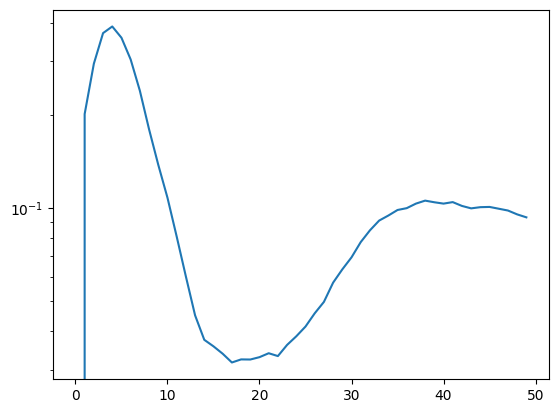

In [597]:
plt.plot(unitarity_scores[:50])
plt.yscale('log')

In [602]:
unitarity_scores[-1]

0.06403048439322845

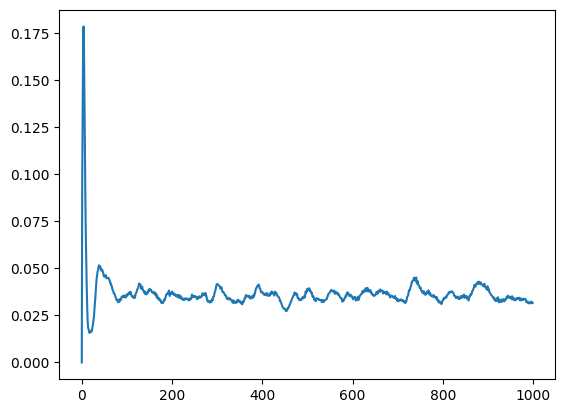

In [598]:
plt.plot(unitary_cost_scores)

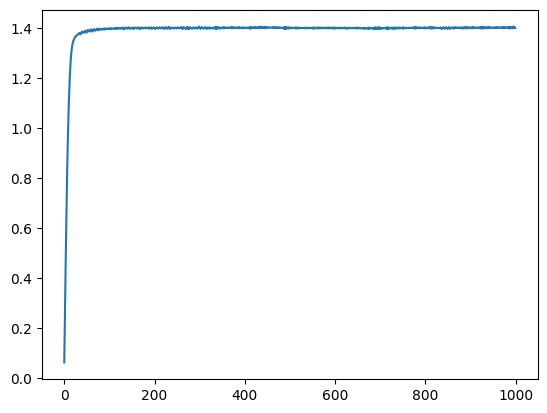

In [599]:
plt.plot(overlap_scores)

In [600]:
overlap_scores[-1]

1.4020294736062502

# Sweep to find unitaries

In [603]:
unitarity_scores = list()
unitary_cost_scores = list()
overlap_scores = list()
target_scores = list()
solutions = list()

lr = 1
num_iterations = 1000

In [604]:
num_sites = 6

In [605]:
matrix_dim = 2**num_sites

In [606]:
for i, l in enumerate(cases):
    print(f"case: {i}")

    unitarity_scores.append(list())
    unitary_cost_scores.append(list())
    overlap_scores.append(list())
    target_scores.append(list())
    solutions.append(list())

    for c in l:
        unitarity_scores[-1].append(list())
        unitary_cost_scores[-1].append(list())
        overlap_scores[-1].append(list())
        target_scores[-1].append(list())
        
        sing_val = c.symmetry_transfer_matrix_singular_vals[0]
        target = np.power(sing_val, -1/2)
        
        current_bs = [
            c.psi.get_B(i)
            for i in range(
                c.right_symmetry_index + 1,
                c.right_symmetry_index + 1 + num_sites
            )
        ]
    
        t = c.right_projected_symmetry_state
        
        for i, b in enumerate(current_bs):
            b_current = b.replace_label('p', f'p{i}')
        
            t = npc.tensordot(t, b_current, [['vR'], ['vL']])
            t = npc.tensordot(t, b_current.conj(), [['vR*'], ['vL*']])
        
        t = npc.trace(t, 'vR', 'vR*')
    
        leg_labels = [f'p{i}' for i in range(NUM_SITES)]
        leg_conj_labels = [f'p{i}*' for i in range(NUM_SITES)]
    
        current_grouped_t = t.combine_legs([leg_labels, leg_conj_labels])
    
        grouped_physical_leg_label = '(' + '.'.join(leg_labels) + ')'
        grouped_physical_leg_conj_label = '(' + '.'.join(leg_conj_labels) + ')'

        current_matrix = get_random_unitary_operator(current_grouped_t, matrix_dim)

        adam_optimizer = AdamTenpy(beta_1 = 0.3, beta_2=0.3, alpha=0.5*1e-2)
        
        for _ in range(num_iterations):
            update(
                current_matrix,
                current_grouped_t,
                unitarity_scores[-1][-1],
                unitary_cost_scores[-1][-1],
                overlap_scores[-1][-1],
                target_scores[-1][-1],
                grouped_physical_leg_label,
                grouped_physical_leg_conj_label,
                matrix_dim,
                unitarity_lr=lr,
                overlap_lr=lr,
                adam_optimizer=adam_optimizer,
                target=target
            )

        solutions[-1].append(current_matrix)

case: 0
case: 1
case: 2
case: 3
case: 4
case: 5
case: 6
case: 7
case: 8
case: 9
case: 10
case: 11
case: 12
case: 13
case: 14
case: 15
case: 16
case: 17
case: 18
case: 19
case: 20


# Convergence analysis

## Unitarity

In [607]:
np.array(unitarity_scores)[:,:,-1]

array([[0.0776931 , 0.07226576, 0.07587054, 0.07368115],
       [0.0769906 , 0.05835928, 0.06519461, 0.06557959],
       [0.06832576, 0.07422601, 0.07207844, 0.07465994],
       [0.08017043, 0.07590726, 0.08292965, 0.08232297],
       [0.08393864, 0.08864292, 0.0726132 , 0.07867464],
       [0.07743602, 0.07251639, 0.07921283, 0.06832393],
       [0.07823323, 0.06937576, 0.07854372, 0.07625704],
       [0.0679106 , 0.07764589, 0.07687798, 0.07895094],
       [0.074405  , 0.07281401, 0.06718811, 0.08872656],
       [0.06673513, 0.08725607, 0.0770125 , 0.08535802],
       [0.06738306, 8.61375596, 0.07785304, 7.71801731],
       [0.07634799, 0.07571281, 0.08473885, 0.07650923],
       [0.06896736, 0.07344801, 0.08784624, 0.06185151],
       [0.07283041, 0.07425607, 0.07081803, 0.07555037],
       [0.07494584, 0.07792113, 0.07794728, 0.07823546],
       [0.07264732, 0.06599266, 0.08284697, 0.06420011],
       [0.07887911, 0.07822357, 0.06502962, 0.06697075],
       [0.0746881 , 0.07590479,

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_82648/1775103944.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


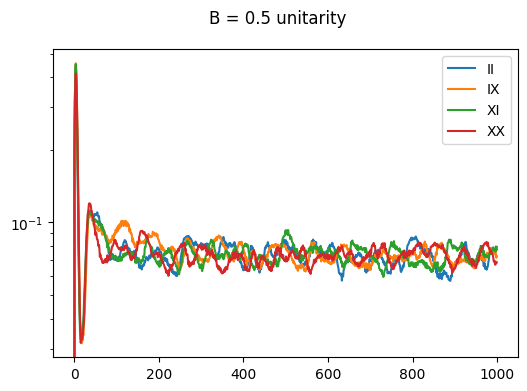

In [608]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(unitarity_scores[5], symmetry_labels):
    ax.plot(scores, label=label)
ax.set_yscale('log')
ax.legend()

fig.suptitle('B = 0.5 unitarity')
fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_82648/3372661539.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


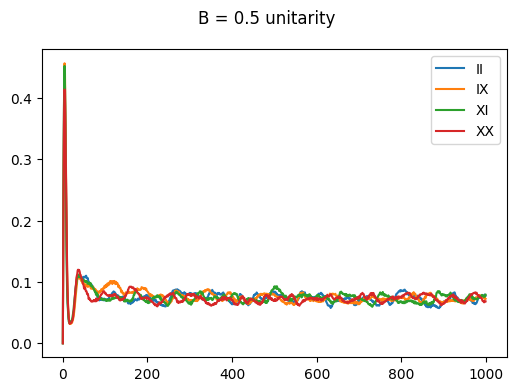

In [609]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(unitarity_scores[5], symmetry_labels):
    ax.plot(scores, label=label)

#ax.set_yscale('log')
ax.legend()

fig.suptitle('B = 0.5 unitarity')
fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_82648/588135298.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


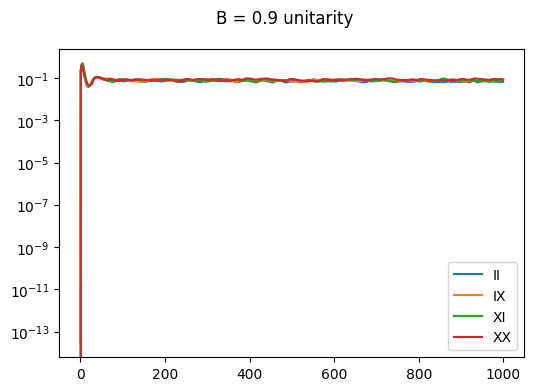

In [610]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(unitarity_scores[9], symmetry_labels):
    ax.plot(scores, label=label)

ax.set_yscale('log')
ax.legend()

fig.suptitle('B = 0.9 unitarity')
fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_82648/3623474513.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


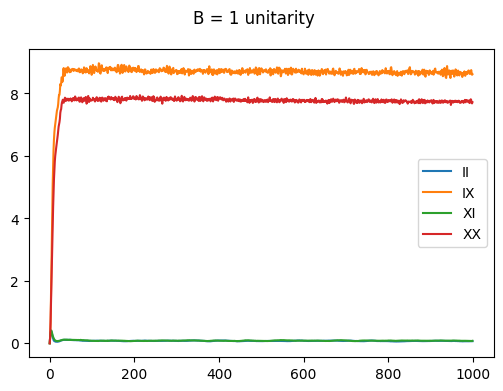

In [611]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(unitarity_scores[10], symmetry_labels):
    ax.plot(scores, label=label)

ax.legend()

fig.suptitle('B = 1 unitarity')
fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_82648/983117741.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


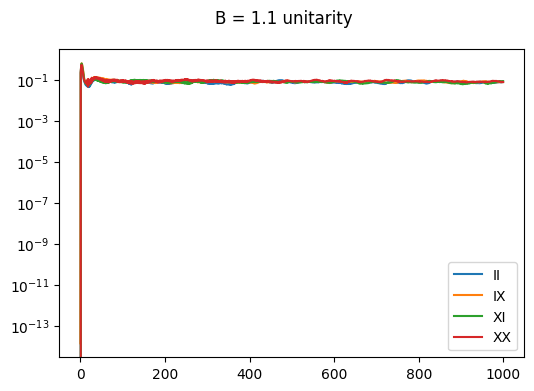

In [612]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(unitarity_scores[11], symmetry_labels):
    ax.plot(scores, label=label)

ax.set_yscale('log')
ax.legend()

fig.suptitle('B = 1.1 unitarity')
fig.show()

Needs further hyperparameter tuning, but otherwise all good.

## Overlaps

In [613]:
np.abs(np.array(overlap_scores)[:,:,-1])

array([[1.40348   , 1.40222896, 1.40398277, 1.40309742],
       [1.40371957, 1.40201876, 1.40400054, 1.40352661],
       [1.40308249, 1.40058033, 1.4049293 , 1.40203177],
       [1.40418023, 1.40170567, 1.40565019, 1.40210044],
       [1.40408036, 1.40245524, 1.40364664, 1.40230947],
       [1.40358637, 1.40381192, 1.40171345, 1.40201028],
       [1.40304424, 1.40170934, 1.40230331, 1.39862997],
       [1.40401486, 1.39642502, 1.39486194, 1.38816945],
       [1.4059994 , 1.38342341, 1.38454316, 1.35733881],
       [1.41047868, 1.34976245, 1.34903612, 1.28044994],
       [1.19703659, 2.06153195, 1.11740207, 1.90896754],
       [1.17526065, 1.13074782, 1.13392272, 1.08153799],
       [1.11828728, 1.09692228, 1.10044168, 1.08299461],
       [1.08678824, 1.0823897 , 1.07727738, 1.072547  ],
       [1.06861917, 1.06531728, 1.0588694 , 1.06190924],
       [1.05352997, 1.04886943, 1.04931352, 1.04770029],
       [1.04288599, 1.03883642, 1.03783387, 1.0345982 ],
       [1.03274059, 1.02853784,

In [614]:
sing_vals = [[c.symmetry_transfer_matrix_singular_vals[0] for c in l] for l in cases]

In [615]:
targets = np.array([[np.power(s, -1/2) for s in l] for l in sing_vals])

In [616]:
np.round(targets - np.abs(np.array(overlap_scores)[:,:,-1]), 3)

array([[0.011, 0.012, 0.01 , 0.011],
       [0.01 , 0.012, 0.01 , 0.011],
       [0.011, 0.014, 0.009, 0.012],
       [0.01 , 0.013, 0.009, 0.012],
       [0.01 , 0.012, 0.011, 0.012],
       [0.012, 0.011, 0.013, 0.013],
       [0.013, 0.015, 0.014, 0.018],
       [0.015, 0.023, 0.024, 0.031],
       [0.019, 0.041, 0.04 , 0.068],
       [0.026, 0.09 , 0.091, 0.163],
       [0.025, 6.455, 0.104, 6.62 ],
       [0.024, 0.069, 0.065, 0.118],
       [0.025, 0.047, 0.043, 0.061],
       [0.024, 0.028, 0.033, 0.038],
       [0.02 , 0.023, 0.03 , 0.027],
       [0.02 , 0.024, 0.024, 0.025],
       [0.019, 0.023, 0.024, 0.027],
       [0.02 , 0.024, 0.023, 0.022],
       [0.021, 0.022, 0.023, 0.022],
       [0.022, 0.022, 0.024, 0.023],
       [0.024, 0.031, 0.023, 0.024]])

Generally pretty ok, but could be better.

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_82648/1457258723.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


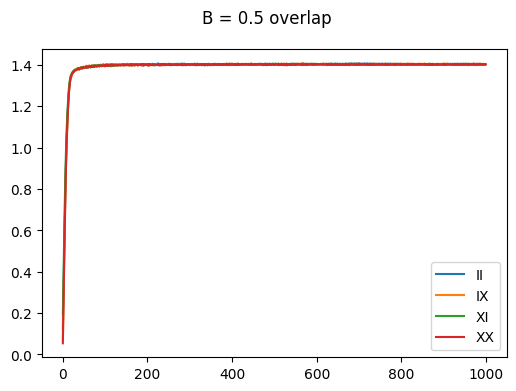

In [617]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(np.abs(overlap_scores[5]), symmetry_labels):
    ax.plot(scores, label=label)

ax.legend()

fig.suptitle('B = 0.5 overlap')
fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_82648/846040587.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


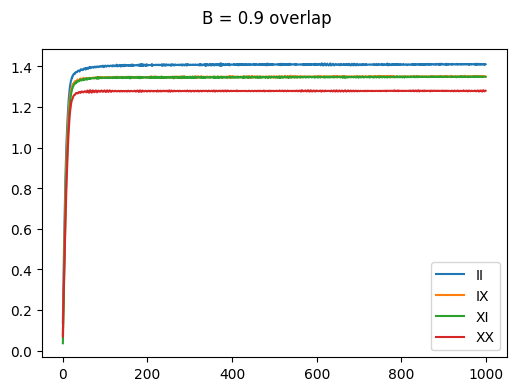

In [618]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(np.abs(overlap_scores[9]), symmetry_labels):
    ax.plot(scores, label=label)

ax.legend()

fig.suptitle('B = 0.9 overlap')
fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_82648/572593937.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


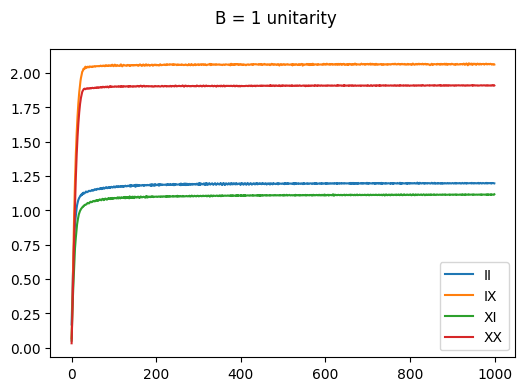

In [619]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(np.abs(overlap_scores[10]), symmetry_labels):
    ax.plot(scores, label=label)

ax.legend()

fig.suptitle('B = 1 unitarity')
fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_82648/1450865751.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


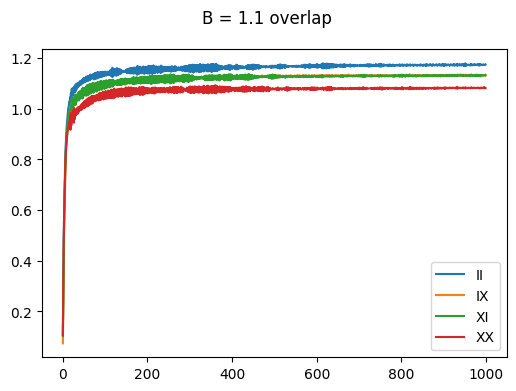

In [620]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(np.abs(overlap_scores[11]), symmetry_labels):
    ax.plot(scores, label=label)

ax.legend()

fig.suptitle('B = 1.1 overlap')
fig.show()

## Target score

In [621]:
np.array(target_scores)[:,:,-1]

array([[1.91175967e-02, 1.78231452e-02, 1.86732314e-02, 1.81547171e-02],
       [1.89458623e-02, 1.44573219e-02, 1.60934925e-02, 1.61916900e-02],
       [1.68613814e-02, 1.83175573e-02, 1.77493738e-02, 1.84034553e-02],
       [1.97075635e-02, 1.87092037e-02, 2.03570412e-02, 2.02483192e-02],
       [2.06166631e-02, 2.17633901e-02, 1.78946339e-02, 1.93712132e-02],
       [1.90646229e-02, 1.78758047e-02, 1.95157514e-02, 1.68847537e-02],
       [1.92790276e-02, 1.71608073e-02, 1.93639345e-02, 1.88716534e-02],
       [1.68120772e-02, 1.93049420e-02, 1.91565890e-02, 1.98401326e-02],
       [1.84462263e-02, 1.87443541e-02, 1.73388318e-02, 2.39940409e-02],
       [1.67423377e-02, 2.53953802e-02, 2.29990035e-02, 3.41405449e-02],
       [1.68793989e-02, 2.18830733e+01, 2.45548706e-02, 2.28857116e+01],
       [1.90257732e-02, 2.09350486e-02, 2.28934343e-02, 2.57129995e-02],
       [1.72724691e-02, 1.91218668e-02, 2.24267574e-02, 1.70619251e-02],
       [1.81658681e-02, 1.86232905e-02, 1.79495053e

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_82648/2222439871.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


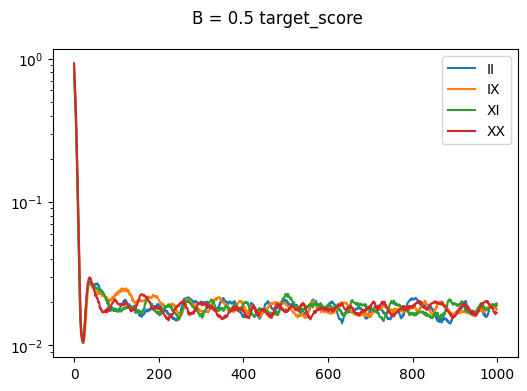

In [622]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(target_scores[5], symmetry_labels):
    ax.plot(scores, label=label)

ax.set_yscale('log')
ax.legend()

fig.suptitle('B = 0.5 target_score')
fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_82648/1728333252.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


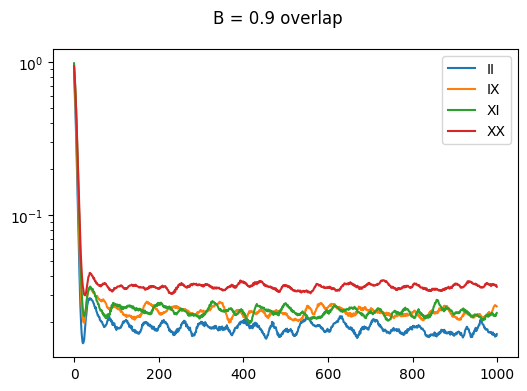

In [623]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(target_scores[9], symmetry_labels):
    ax.plot(scores, label=label)

ax.set_yscale('log')
ax.legend()

fig.suptitle('B = 0.9 overlap')
fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_82648/2192447709.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


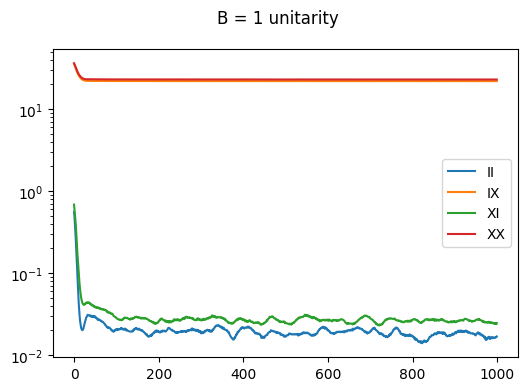

In [624]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(target_scores[10], symmetry_labels):
    ax.plot(scores, label=label)

ax.set_yscale('log')
ax.legend()

fig.suptitle('B = 1 unitarity')
fig.show()

/var/folders/r3/xn8xq5c17932m2g1b4r3dss80000gn/T/ipykernel_82648/3726596553.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


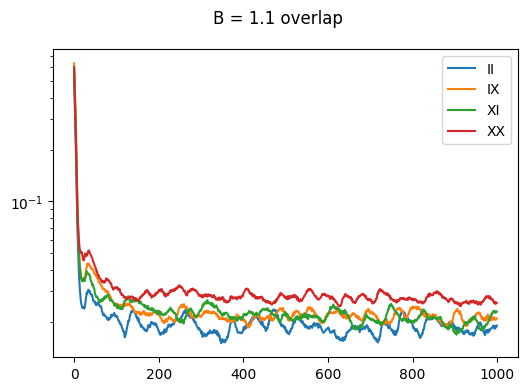

In [625]:
fig, ax = plt.subplots(figsize=(6, 4))

for scores, label in zip(target_scores[11], symmetry_labels):
    ax.plot(scores, label=label)

ax.set_yscale('log')
ax.legend()

fig.suptitle('B = 1.1 overlap')
fig.show()

# Extract SPT phase

### Functions

In [626]:
from itertools import combinations

In [627]:
symmetry_combination_labels = list(combinations(symmetry_labels, 2))

In [628]:
symmetry_combination_labels

[('II', 'IX'),
 ('II', 'XI'),
 ('II', 'XX'),
 ('IX', 'XI'),
 ('IX', 'XX'),
 ('XI', 'XX')]

In [629]:
def get_reduced_tensor_matrix(symmetry_case, num_sites=NUM_SITES, normalise=False):
    mps_tensors = [
        symmetry_case.psi.get_B(i)
        for i in range(
            symmetry_case.right_symmetry_index + 1,
            symmetry_case.right_symmetry_index + 1 + num_sites
        )
    ]

    rdm = symmetry_case.right_projected_symmetry_state

    if normalise:
        normalisation = npc.trace(rdm, 'vR', 'vR*')
        norm_phase = normalisation/np.abs(normalisation)
    
        rdm *= norm_phase.conj()

    for i, b in enumerate(mps_tensors):
        b_current = b.replace_label('p', f'p{i}')
    
        rdm = npc.tensordot(rdm, b_current, [['vR'], ['vL']])
        rdm = npc.tensordot(rdm, b_current.conj(), [['vR*'], ['vL*']])
    
    rdm = npc.trace(rdm, 'vR', 'vR*')

    leg_labels = [f'p{i}' for i in range(num_sites)]
    leg_conj_labels = [f'p{i}*' for i in range(num_sites)]

    rdm = rdm.combine_legs([leg_labels, leg_conj_labels])

    return rdm

In [630]:
def get_grouped_leg_labels(num_sites):
    leg_labels = [f'p{i}' for i in range(num_sites)]
    leg_conj_labels = [f'p{i}*' for i in range(num_sites)]

    grouped_physical_leg_label = '(' + '.'.join(leg_labels) + ')'
    grouped_physical_leg_conj_label = '(' + '.'.join(leg_conj_labels) + ')'

    return (grouped_physical_leg_label, grouped_physical_leg_conj_label)

In [631]:
def multiply_tenpy_matrices(m1, m2, grouped_physical_leg_label='p',
                            grouped_physical_leg_conj_label='p*'):
    return npc.tensordot(
        m1,
        m2,
        [
            [grouped_physical_leg_label,],
            [grouped_physical_leg_conj_label,]
        ]
    )

In [632]:
def distance_from_identity(j, dim=2, grouped_physical_leg_label='p',
                            grouped_physical_leg_conj_label='p*'):
    # Assumes two dimensions

    p1 = grouped_physical_leg_label
    p2 = grouped_physical_leg_conj_label
    e1 = npc.tensordot(j, j.conj(), [[p1, p2], [p2, p1]])

    e2 = npc.trace(j, p1, p2)

    return e1 - 2*e2.real + dim

In [633]:
def gauge_invariant_phase(u1, u2, dim=2, grouped_physical_leg_label='p',
                            grouped_physical_leg_conj_label='p*'):
    def multiply(m1, m2):
        return multiply_tenpy_matrices(
            m1,
            m2,
            grouped_physical_leg_label,
            grouped_physical_leg_conj_label
        )

    u = reduce(multiply, [u1, u2, u1.conj(), u2.conj()])

    trace = npc.trace(
        u,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label
    )

    phase = trace/abs(trace)

    approx_identity = u/phase
    approx_identity_distance = distance_from_identity(
        approx_identity,
        dim,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label
    )

    return phase, approx_identity_distance

In [634]:
def state_gauge_invariant_phase(u1, u2, rdm_tensor, dim=2, grouped_physical_leg_label='p',
                            grouped_physical_leg_conj_label='p*'):
    def multiply(m1, m2):
        return multiply_tenpy_matrices(
            m1,
            m2,
            grouped_physical_leg_label,
            grouped_physical_leg_conj_label
        )

    t = reduce(multiply, [u1, u2, u1.conj(), u2.conj(), rdm_tensor])

    trace = npc.trace(
        t,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label
    )

    phase = trace/abs(trace)

    return phase

In [635]:
def get_state_phases(solutions, rdm_tensor, matrix_dim,
                     grouped_physical_leg_label,
                     grouped_physical_leg_conj_label):
    # To-do: Automatically get all info. Should only need cases input argument
    solution_pairs = combinations(solutions, 2)

    out = [
        state_gauge_invariant_phase(
            *p,
            rdm_tensor,
            matrix_dim,
            grouped_physical_leg_label,
            grouped_physical_leg_conj_label
        )
        for p in solution_pairs
    ]

    return out

## Calculation

In [636]:
grouped_physical_leg_label, grouped_physical_leg_conj_label = get_grouped_leg_labels(NUM_SITES)

In [637]:
phase_distance_pairs = [
    [
        gauge_invariant_phase(
            *p,
            matrix_dim,
            grouped_physical_leg_label,
            grouped_physical_leg_conj_label
        )
        for p in combinations(l, 2)
    ]
    for l in solutions
]

In [638]:
phases = [[p[0] for p in l] for l in phase_distance_pairs]
distances = [[p[1] for p in l] for l in phase_distance_pairs]

In [639]:
state_phases = list()

for l, c in zip(solutions, cases):
    rdm = get_reduced_tensor_matrix(c[0], NUM_SITES, normalise=True)

    state_data = get_state_phases(
        l,
        rdm,
        matrix_dim,
        grouped_physical_leg_label,
        grouped_physical_leg_conj_label
    )

    state_phases.append(state_data)

## Projective rep phases

In [640]:
np.round(phases[:10], 3)

array([[ 0.984+0.179j,  0.996+0.088j,  1.   -0.007j, -0.986+0.166j,
        -1.   +0.03j , -0.96 -0.28j ],
       [ 0.979-0.204j,  0.938+0.347j,  0.997-0.082j, -0.996+0.093j,
        -0.982+0.187j, -0.99 +0.141j],
       [ 0.998-0.06j ,  0.998-0.058j,  0.981-0.195j, -0.947+0.321j,
        -0.991+0.133j, -0.999+0.043j],
       [ 0.992+0.127j,  1.   -0.017j,  0.992-0.124j, -0.939+0.345j,
        -0.988-0.152j, -0.998-0.066j],
       [ 1.   +0.008j,  0.999-0.032j,  0.982+0.19j , -0.996+0.095j,
        -0.953+0.304j, -0.989+0.147j],
       [ 0.954-0.301j,  0.999+0.054j,  0.891+0.455j, -1.   +0.013j,
        -0.999+0.045j, -0.989-0.146j],
       [ 0.971+0.24j ,  0.985-0.171j,  0.999+0.049j, -0.992-0.126j,
        -1.   +0.028j, -0.962-0.272j],
       [ 1.   +0.019j,  0.973+0.231j,  0.998-0.067j, -0.986+0.164j,
        -0.999+0.041j, -0.997+0.082j],
       [ 0.995+0.102j,  0.997+0.082j,  0.962-0.274j, -0.999-0.045j,
        -0.948-0.319j, -0.997+0.079j],
       [ 0.993-0.118j,  0.971+0.24j ,

In [641]:
phases[10]

[(0.9979143748509877+0.06455153341139488j),
 (0.9876946695988338-0.15639450005051544j),
 (0.9959124041259986+0.09032432290348763j),
 (-0.9995359709917352-0.030460510396397297j),
 (-0.9997220266518329+0.023576883321428155j),
 (-0.9999979680866496+0.00201589250008345j)]

In [642]:
np.round(phases[11:], 3)

array([[ 0.954-0.299j,  0.948+0.318j,  1.   -0.012j,  0.987-0.159j,
         0.991-0.131j,  0.999-0.048j],
       [ 1.   +0.017j,  1.   +0.028j,  1.   +0.01j ,  0.998-0.06j ,
         1.   -0.022j,  0.998-0.056j],
       [ 0.999-0.041j,  0.998+0.06j ,  0.948+0.319j,  1.   +0.022j,
         0.99 +0.143j,  1.   +0.j   ],
       [ 0.919+0.395j,  0.977-0.214j,  1.   -0.012j,  1.   +0.014j,
         0.976+0.22j ,  0.972-0.236j],
       [ 0.996-0.089j,  0.913-0.408j,  0.991+0.132j,  0.992+0.126j,
         0.998+0.061j,  0.992-0.124j],
       [ 0.989-0.15j ,  0.993+0.114j,  1.   -0.019j,  0.994+0.106j,
         0.994-0.106j,  0.99 +0.138j],
       [ 0.986+0.166j,  0.957+0.291j,  1.   +0.008j, -0.233-0.973j,
         0.914-0.405j,  0.967+0.254j],
       [ 0.963-0.271j,  0.998-0.06j ,  1.   +0.02j ,  1.   +0.019j,
         0.987-0.159j,  1.   -0.005j],
       [ 0.999+0.036j,  0.983-0.183j,  0.796+0.605j,  0.96 +0.28j ,
         0.429+0.903j,  0.972-0.235j],
       [ 0.682+0.732j,  0.962-0.274j,

## State phases

In [643]:
np.real(np.round(np.array(state_phases), 2))

array([[ 1.,  1.,  1., -1., -1., -1.],
       [ 1.,  1.,  1., -1., -1., -1.],
       [ 1.,  1.,  1., -1., -1., -1.],
       [ 1.,  1.,  1., -1., -1., -1.],
       [ 1.,  1.,  1., -1., -1., -1.],
       [ 1.,  1.,  1., -1., -1., -1.],
       [ 1.,  1.,  1., -1., -1., -1.],
       [ 1.,  1.,  1., -1., -1., -1.],
       [ 1.,  1.,  1., -1., -1., -1.],
       [ 1.,  1.,  1., -1., -1., -1.],
       [ 1.,  1.,  1., -1., -1., -1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.]])

Looks good!

# Conclusions

* It works!
* May have better performance than naive GD, given hyperparameter tuning.
* "Heavy" damping on first and second moments seems to work better.
* Occassionally diverging, likely due to quartic term in unitarity cost. Would work better with hyperbolic cost function?